In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U duckduckgo_search
    !pip install fastai
    !pip install fastbook
    
import fastbook
fastbook.setup_book()

  Obtaining dependency information for duckduckgo_search from https://files.pythonhosted.org/packages/97/8e/01d4aea1f9fdac45973d2f1d07d29832a243f91106e10d8ffb442adf4f4d/duckduckgo_search-4.2-py3-none-any.whl.metadata
  Obtaining dependency information for curl-cffi>=0.5.10 from https://files.pythonhosted.org/packages/93/04/0d57a51690451437f72563031036ea4f4b529bc0cfd8e8d93487075cbe80/curl_cffi-0.5.10-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.1 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 32.5 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

In [4]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

Search rabbit images

In [5]:
ims = search_images_ddg('rabbit')
len(ims)

200

Rabbit image

In [6]:
dest = 'images/rabbit.jpg'
download_url(ims[0], dest, show_progress=False)

Path('images/rabbit.jpg')

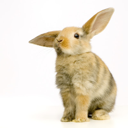

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

Search squirrel images

In [8]:
searches = 'squirrel','rabbit'
path = Path('rabbit_or_squirrel')

In [9]:
from time import sleep

if not path.exists():
    path.mkdir()
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images_ddg(f'brown {o}'))
        sleep(10)  # Pause between searches to avoid over-loading server
        download_images(dest, urls=search_images_ddg(f'white {o}'))
        sleep(10)
        resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Remove failed images

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

29

## From Data to DataLoaders

In [11]:
rabbits_squirrels = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = rabbits_squirrels.dataloaders(path)

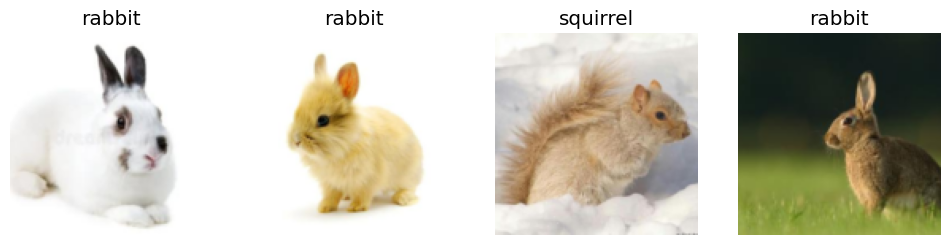

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

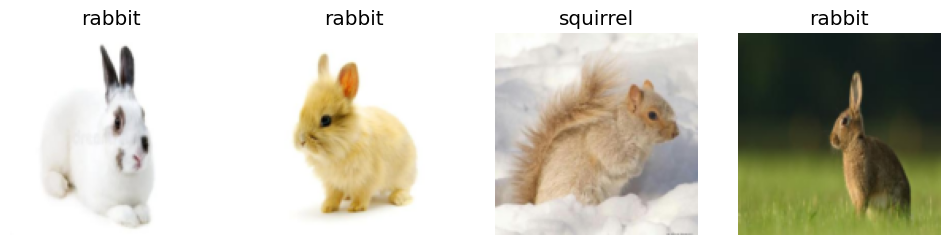

In [14]:
rabbits_squirrels = rabbits_squirrels.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = rabbits_squirrels.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

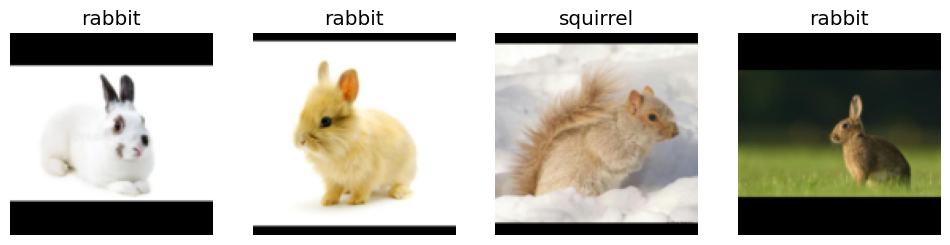

In [15]:
rabbits_squirrels = rabbits_squirrels.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = rabbits_squirrels.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

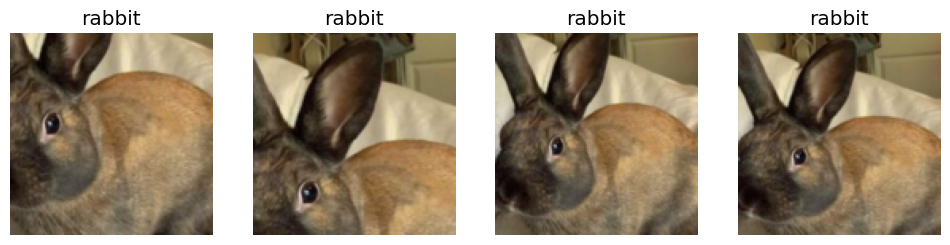

In [16]:
rabbits_squirrels = rabbits_squirrels.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = rabbits_squirrels.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

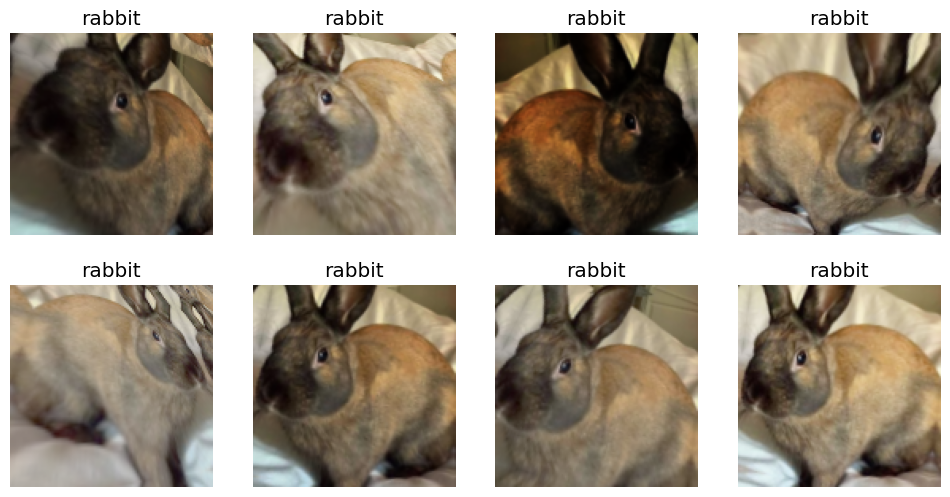

In [17]:
rabbits_squirrels = rabbits_squirrels.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = rabbits_squirrels.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Model, and Using It to Clean Data

In [18]:
rabbits_squirrels = rabbits_squirrels.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = rabbits_squirrels.dataloaders(path)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.766365,0.040405,0.020979,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.095226,0.057927,0.020979,00:02
1,0.118580,0.050912,0.006993,00:02
2,0.095192,0.058157,0.013986,00:02
3,0.076599,0.068668,0.020979,00:02


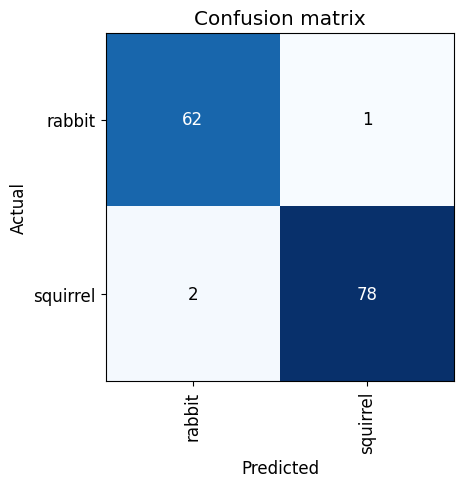

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

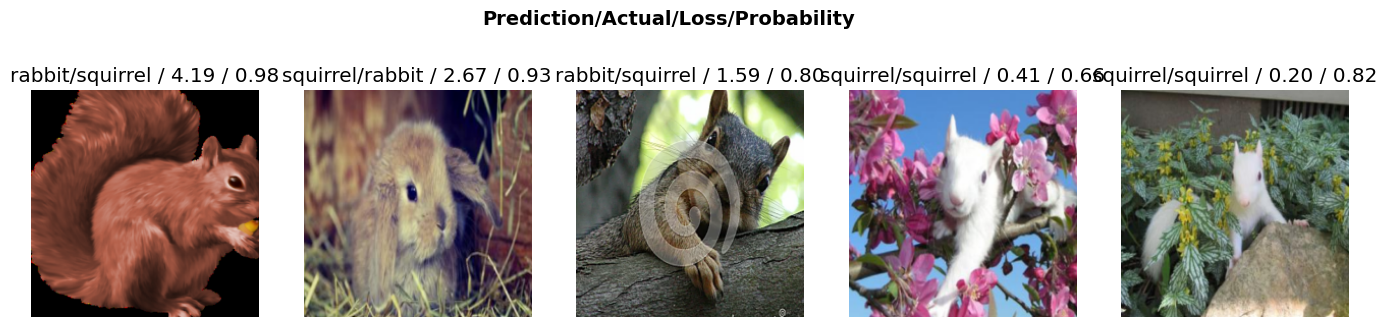

In [21]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

Clean data

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Export Model

In [24]:
learn.export('model.pkl')